In [22]:
from tqdm import tqdm
import pandas as pd

In [23]:
# %load_ext filprofiler

In [24]:
import networkx as nx
from networkx.algorithms.community.quality import modularity
import pycombo
from cdlib import algorithms
import community as community_louvain

In [25]:
from typing import List

def _partition_sets(p:dict)->List[set]:
    '''converts partition as a dict of labels
    into list of sets of nodes
    '''
    P = dict()
    for k, v in p.items():
        P[v] = P.get(v, set())
        P[v].add(k)
    return list(P.values())

def _partition_sets_cdlib(p:List[list])->List[set]:
    return [set(v) for v in p]
    

# 1. Karate

In [26]:
G = nx.karate_club_graph()

In [27]:
partition_combo, mod = pycombo.execute(G, return_modularity=True, random_seed=42)
partition_louvain = community_louvain.best_partition(G)

In [28]:
mod

0.444903581267218

In [29]:
p = _partition_sets(partition_combo)
m_combo = modularity(G, p)
print(f'Combo Modularity: {m_combo:,.4f}')

Combo Modularity: 0.4449


In [30]:
p = _partition_sets(partition_louvain)
m_louvain = modularity(G, p)
print(f'Louvain Modularity: {m_louvain:,.4f}')

Louvain Modularity: 0.4439


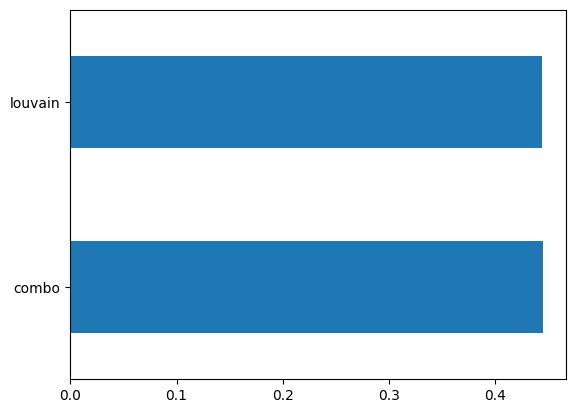

In [31]:
pd.Series({
    'combo': m_combo,
    'louvain': m_louvain,
}).plot(kind='barh');

#### Performance

In [32]:
%timeit pycombo.execute(G, return_modularity=True, random_seed=42)

277 µs ± 2.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [34]:
%timeit community_louvain.best_partition(G)

703 µs ± 2.11 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


#### Memory

In [33]:
# %%filprofile
# community_louvain.best_partition(G)

In [35]:
# %%filprofile
# pycombo.execute(G, return_modularity=True, random_seed=42)

# 2. Erdos-Reniy

In [36]:
Ns = range(100, 1001, 100)

In [37]:
ALGOS = {
    'pycombo' : lambda G: pycombo.execute(G, return_modularity=True, random_seed=42),
    'comm_louvain': lambda G: community_louvain.best_partition(G, randomize=False),
    'cdlib_louvain': lambda G: algorithms.louvain(G, weight='weight', resolution=1., randomize=False),
    'cdlib_surprise': lambda G:  algorithms.surprise_communities(G),
    'cdlib_leiden': lambda G:  algorithms.leiden(G),
    'cdlib_walktrap': lambda G: algorithms.walktrap(G)
    
}

In [38]:
RESULTS = dict()

for n in tqdm(Ns):
    G = nx.generators.random_graphs.erdos_renyi_graph(n=n, p=0.15, seed=42)
    RESULTS[n] = dict()
    
    for k, func in ALGOS.items():
        try:
            if k == 'pycombo':
                _, mod = func(G)

            else:
                partition = func(G)
                if 'cdlib' in k:
                    pset = _partition_sets_cdlib(partition.communities)
                else:
                    pset = _partition_sets(partition)
                mod = modularity(G, pset)

            RESULTS[n][k] = mod
        except Exception as e:
            raise Exception(n, k, e)

100%|██████████| 10/10 [00:32<00:00,  3.21s/it]


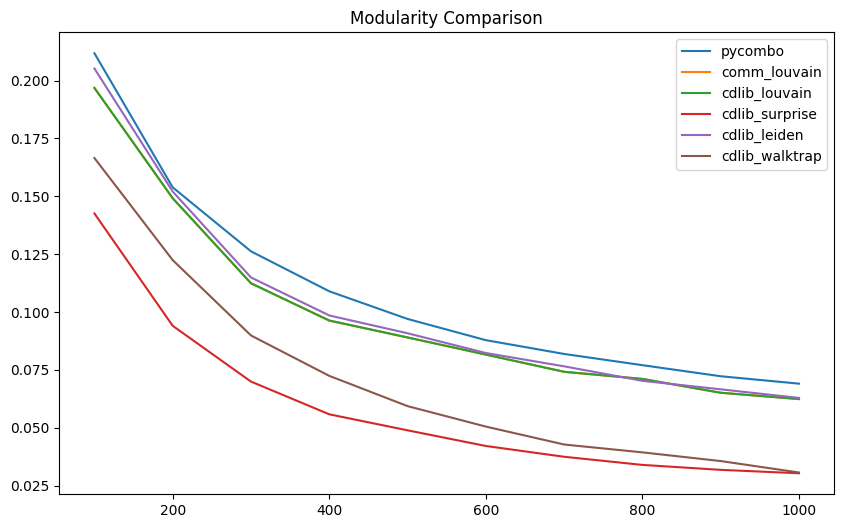

In [39]:
pd.DataFrame(RESULTS).T.plot(title='Modularity Comparison',figsize=(10,6));

### Time Comparison

In [40]:
import timeit 
REPEATS = 5
  

SETUP_CODE = ''' 
import pycombo
import community as community_louvain
import networkx as nx
from cdlib import algorithms
G = nx.generators.random_graphs.erdos_renyi_graph(n={n}, p=0.15, seed=42)
'''

ALGOS_STR = {
    'pycombo' : "pycombo.execute(G, return_modularity=True, random_seed=42)",
    'comm_louvain': "community_louvain.best_partition(G, randomize=False)",
    'cdlib_louvain': "algorithms.louvain(G, weight='weight', resolution=1., randomize=False)",
    'cdlib_surprise': "algorithms.surprise_communities(G)",
    'cdlib_leiden': "algorithms.leiden(G)",
    'cdlib_walktrap': "algorithms.walktrap(G)"
    
}

def timeit_comm(n:int, test_code:str)->List[int]: 
      
    # timeit.repeat statement 
    return timeit.repeat(setup = SETUP_CODE.format(n=n), 
                          stmt = test_code, 
                          repeat = REPEATS, 
                          number = 1) 

In [41]:
from statistics import mean

PERF = dict()

for n in tqdm(Ns):
    PERF[n] = dict()
    for k, code in ALGOS_STR.items():
        times = timeit_comm(n, test_code=code)
        PERF[n][k] = mean(times)
    

100%|██████████| 10/10 [02:31<00:00, 15.20s/it]


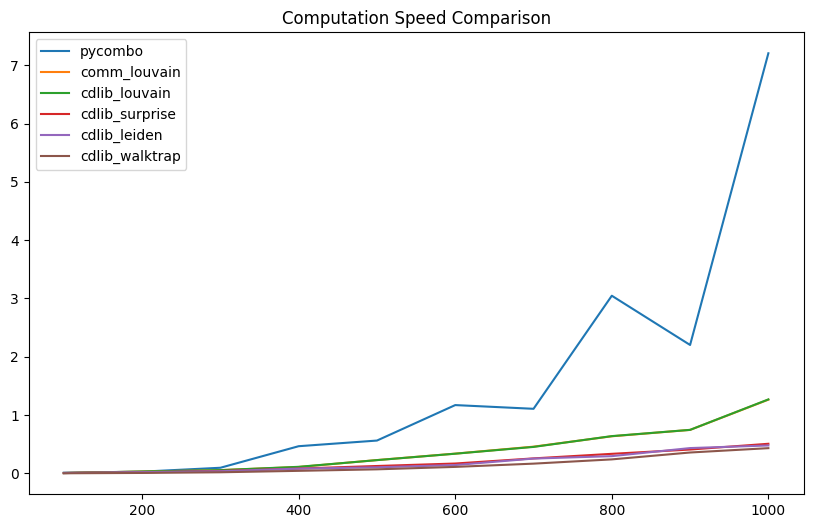

In [42]:
pd.DataFrame(PERF).T.iloc[:10, :].plot(title='Computation Speed Comparison',figsize=(10,6));